### Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
%matplotlib inline
import statsmodels.api as sm
import itertools
from math import sqrt
from sklearn.metrics import mean_squared_error as MSE

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

def get_datetimes(df,start_col=1):
    return pd.to_datetime(df.columns.values[start_col:], format='%Y-%m')

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
df = pd.read_csv("zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [2]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [3]:
# Create ACF & PACF Plots
def acf_pacf(df,alags=48,plags=48):
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,12))
    plot_acf(df,lags=alags, zero=False,ax=ax1)
    plot_pacf(df,lags=plags, ax=ax2)
    plt.show()

In [4]:
# Check ACF plot for seasonality by differencing rolling mean
def seasonal_plots(df,N=13,lags=[12,24,36,48,60,72]):
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,12))
    rolling = ts_30080 - ts_30080.rolling(N).mean()
    plot_acf(rolling.dropna(),lags=lags,ax=ax1)
    plot_pacf(rolling.dropna(),lags=lags,ax=ax2)
    plt.show();

In [5]:
def train_test(df):
    #Set training data before 2016
    train = df[:'2015-04']
    #Set test data starting 2016
    test = df['2015-05':]
    return train, test

In [6]:
#def model_fit(df,pdq=(2,1,1),pdqs=(0,0,1,12)):
#    train, test = train_test(df)
#    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
#    results = model.fit()
#    results.summary
#    residuals = results.resid
#    print(results.summary())
#    results.plot_diagnostics(figsize=(11,8))
#    plt.show();
#    return train, test, results

# changing pdq/pdqs in first definition for my model

In [7]:
def test_RMSE(df,pdq=(2,1,1),pdqs=(0,0,1,12), display=True):
    X = df.values
    train, test = X[:-36],X[-36:]
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=pdq,seasonal_order=pdqs)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-36:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='g')
        plt.legend(loc='best')
        plt.show()

In [8]:
def train_RMSE(train, results, display = True):
    train_pred = results.predict(-36)
    rmse = sqrt(MSE(train[-36:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[-60:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='g')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Returns')
        plt.show()

In [9]:
def forecast_model(df,pdq=(2,1,1),pdqs=(0,0,1,12), display=True,z='input zipcode'):
    model = SARIMAX(df, order=pdq,seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04',end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Expected 1yr return: {round(year_1*100,2)}%')
    print(f'Expected 3yr return: {round(year_3*100,2)}%')
    print(f'Expected 5yr return: {round(year_5*100,2)}%')
    print(f'Expected 10yr return: {round(year_10*100,2)}%')
    tot_mr = [z,year_1,year_3,year_5,year_10]
    return tot_mr

#changed ret to mr and zc to z

In [10]:
import helper_functions as hf

In [11]:
from importlib import reload
from helper_functions import hf_ml as hfm
from helper_functions import hf_arima as hfa

In [12]:
reload(hf)

<module 'helper_functions' from '/Users/bryanjamieson/flatiron/dsc-mod-4-project-online-ds-ft-090919/helper_functions/__init__.py'>

In [13]:
hfa.summ(3, 5)

8

In [14]:
# Created new dataframe called df_GA containing only data from counties in Georgia
# region name = zipcode

df_GA = df.loc[df["State"] == 'GA']
df_GA.head(15)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
28,71067,30349,Riverdale,GA,Atlanta,Clayton,29,90900.0,91100.0,91200.0,...,118700,119900,121400,122900,123800,124600,126200,127300,127700,128100
42,70829,30044,Lawrenceville,GA,Atlanta,Gwinnett,43,111400.0,111800.0,112200.0,...,169500,170900,172800,174700,176400,178500,180100,181000,182200,183400
51,70828,30043,Lawrenceville,GA,Atlanta,Gwinnett,52,135200.0,135500.0,135800.0,...,213600,216000,218400,220300,221900,223700,225500,226700,227800,228800
65,70874,30096,Duluth,GA,Atlanta,Gwinnett,66,119700.0,120000.0,120300.0,...,205900,207600,209400,211200,212700,214600,216500,218100,219800,221100
78,70810,30024,Suwanee,GA,Atlanta,Gwinnett,79,179600.0,181000.0,182400.0,...,330100,331700,333400,334800,336100,338600,341300,343200,344900,346300
101,71005,30281,Stockbridge,GA,Atlanta,Henry,102,94300.0,95700.0,97100.0,...,145100,146400,147400,148200,149300,149900,149400,149500,150800,151700
176,70825,30040,Cumming,GA,Atlanta,Forsyth,177,145200.0,145400.0,145900.0,...,277200,278300,279900,281600,283400,285900,288100,290000,292100,293200
177,70953,30188,Woodstock,GA,Atlanta,Cherokee,178,119200.0,119500.0,119800.0,...,213900,215100,216400,218200,220700,223200,225200,227100,229200,230800
213,70859,30080,Smyrna,GA,Atlanta,Cobb,214,133000.0,133100.0,133100.0,...,282400,284400,286900,290000,293700,297100,299400,302400,307100,311000
221,70842,30062,Marietta,GA,Atlanta,Cobb,222,150000.0,150500.0,150900.0,...,309200,310600,313300,316500,319100,321400,323100,324700,327000,328700


In [15]:
df_GA['CountyName'].unique()

array(['Clayton', 'Gwinnett', 'Henry', 'Forsyth', 'Cherokee', 'Cobb',
       'Fulton', 'Douglas', 'Chatham', 'Muscogee', 'Houston', 'Coweta',
       'Dekalb', 'Columbia', 'Clarke', 'Newton', 'Whitfield', 'Baldwin',
       'Hall', 'Catoosa', 'Bartow', 'Barrow', 'Floyd', 'Bulloch', 'Bibb',
       'Gordon', 'Fayette', 'Carroll', 'Lowndes', 'Murray', 'Walker',
       'Dougherty', 'Troup', 'Rockdale', 'Glynn', 'Dawson', 'Laurens',
       'Bryan', 'Tift', 'Lumpkin', 'Spalding', 'Pickens', 'Upson',
       'Walton', 'Lee', 'White', 'Thomas', 'Putnam', 'Stephens', 'Union',
       'Polk', 'Jackson', 'Butts', 'Gilmer', 'Effingham', 'Colquitt',
       'Camden', 'Peach', 'Ware', 'Hart', 'Greene', 'Fannin', 'Monroe',
       'Coffee', 'Habersham', 'Jones', 'Haralson', 'Morgan', 'Lamar',
       'Rabun', 'Liberty', 'Oconee', 'Madison', 'Harris', 'Wayne', 'Pike',
       'Banks', 'Wilcox', 'Calhoun'], dtype=object)

In [16]:
# After taking a look at the list of counties in Georgia, I picked 3 counties that I think real estate prices will 
# increase a lot in price over the next 10 years.

In [17]:
# New df "GA_Counties" contains real estate data only from the 3 counties I am looking into.

GA_Counties = ["Fulton", "Dekalb", "Cobb"]

In [18]:
df_GA_2 = df_GA.loc[(df_GA["CountyName"] == "Fulton")|
          (df_GA["CountyName"] == "Dekalb")|
          (df_GA["CountyName"] == "Cobb")]

In [19]:
# Here we are looking at the city names within our 3 counties
# buckhead,roswell,atlanta
df_GA_2["City"].unique()

array(['Smyrna', 'Marietta', 'Atlanta', 'Johns Creek', 'Powder Springs',
       'Milton', 'Lithonia', 'Acworth', 'Roswell', 'Kennesaw',
       'Brookhaven', 'Candler-Mcafee', 'Panthersville', 'Vinings',
       'Sandy Springs', 'Mableton', 'Tucker', 'Dunwoody', 'Fairburn',
       'Conley', 'North Decatur', 'Stone Mountain', 'North Druid Hills',
       'Chamblee', 'Decatur', 'Alpharetta', 'Austell', 'Union City',
       'Palmetto', 'Avondale Estates', 'Scottdale'], dtype=object)

In [20]:
#df_GA_2[df.loc["Fulton"]]
df_GA_2.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
213,70859,30080,Smyrna,GA,Atlanta,Cobb,214,133000.0,133100.0,133100.0,...,282400,284400,286900,290000,293700,297100,299400,302400,307100,311000
221,70842,30062,Marietta,GA,Atlanta,Cobb,222,150000.0,150500.0,150900.0,...,309200,310600,313300,316500,319100,321400,323100,324700,327000,328700
227,71050,30331,Atlanta,GA,Atlanta,Fulton,228,97100.0,97700.0,98400.0,...,130300,131300,132700,134000,135100,137000,139400,140800,141500,141600
254,70808,30022,Johns Creek,GA,Atlanta,Fulton,255,206900.0,207300.0,207800.0,...,393700,393900,395400,396600,397600,399600,402400,405100,407800,409000
296,70904,30127,Powder Springs,GA,Atlanta,Cobb,297,119300.0,119300.0,119300.0,...,182600,183600,185300,187300,189000,190600,192100,194000,197100,199500


In [21]:
dates = df_GA_2.columns[7:]
print(dates)

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=265)


In [22]:
new_df  = pd.DataFrame()
new_df['dates'] = get_datetimes(df,7)

In [23]:
for zipcode in df.RegionName:
    row = df[df.RegionName==zipcode].iloc[:,7:]
    new_df[zipcode] = row.values[0]
new_df.set_index('dates',inplace=True)

In [24]:
print(new_df.shape)
new_df.head()

(265, 14723)


,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
dates,,,,,,,,,,,,,,,,,,,,,
1996-04-01,334200.0,235700.0,210400.0,498100.0,77300.0,95000.0,152900.0,216500.0,95400.0,766000.0,...,80800.0,135900.0,78300.0,136200.0,62500.0,94600.0,92700.0,57100.0,191100.0,176400.0
1996-05-01,335400.0,236900.0,212200.0,500900.0,77300.0,95200.0,152700.0,216700.0,95600.0,771100.0,...,80100.0,136300.0,78300.0,136600.0,62600.0,94300.0,92500.0,57300.0,192400.0,176300.0
1996-06-01,336500.0,236700.0,212200.0,503100.0,77300.0,95400.0,152600.0,216900.0,95800.0,776500.0,...,79400.0,136600.0,78200.0,136800.0,62700.0,94000.0,92400.0,57500.0,193700.0,176100.0
1996-07-01,337600.0,235400.0,210700.0,504600.0,77300.0,95700.0,152400.0,217000.0,96100.0,781900.0,...,78600.0,136900.0,78200.0,136800.0,62700.0,93700.0,92200.0,57700.0,195000.0,176000.0
1996-08-01,338500.0,233300.0,208300.0,505500.0,77400.0,95900.0,152300.0,217100.0,96400.0,787300.0,...,77900.0,137100.0,78100.0,136700.0,62700.0,93400.0,92100.0,58000.0,196300.0,175900.0


In [25]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Columns: 14723 entries, 60657 to 89155
dtypes: float64(14723)
memory usage: 29.8 MB


In [26]:
Fulton_zipcodes = list(df_GA_2[df_GA_2.CountyName=='Fulton']['RegionName'])
Dekalb_zipcodes = list(df_GA_2[df_GA_2.CountyName=='Dekalb']['RegionName'])
Cobb_zipcodes = list(df_GA_2[df_GA_2.CountyName=='Cobb']['RegionName'])

In [27]:
print(Fulton_zipcodes)

[30331, 30022, 30004, 30075, 30309, 30076, 30324, 30350, 30328, 30316, 30305, 30213, 30342, 30308, 30005, 30306, 30327, 30307, 30291, 30009, 30317, 30326, 30268, 30363]


In [28]:
print(Dekalb_zipcodes)

[30058, 30319, 30032, 30034, 30038, 30084, 30338, 30294, 30033, 30087, 30329, 30341, 30030, 30360, 30288, 30002, 30079]


In [29]:
print(Cobb_zipcodes)

[30080, 30062, 30127, 30066, 30101, 30067, 30144, 30064, 30339, 30126, 30152, 30102, 30060, 30068, 30082, 30008, 30168, 30106]


In [30]:
summary_df = pd.DataFrame()
summary_df['Region'] = new_df.mean(axis=1)
summary_df['Fulton'] = new_df[Fulton_zipcodes].mean(axis=1)
summary_df['Dekalb'] = new_df[Dekalb_zipcodes].mean(axis=1)
summary_df['Cobb'] = new_df[Cobb_zipcodes].mean(axis=1)

In [31]:
font = {
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [32]:
plt.gcf().autofmt_xdate()

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, '$')

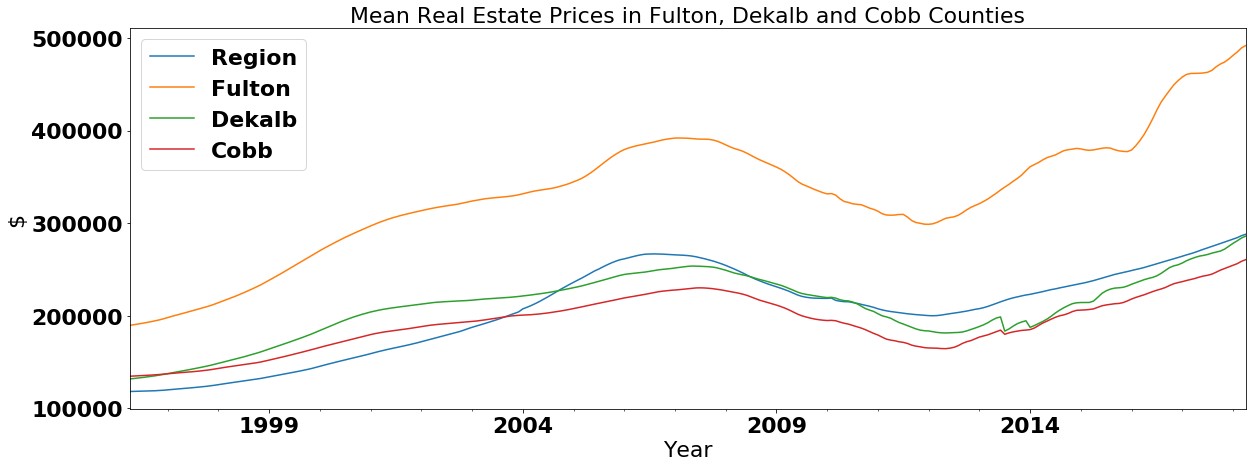

In [33]:
summary_df.plot(figsize=(20,7),legend=True)
plt.title("Mean Real Estate Prices in Fulton, Dekalb and Cobb Counties",{'size':22});
plt.xlabel("Year",{'size':22})
plt.ylabel("$",{'size':22})

## Zip Code Selection

In [34]:
# Zip Code Selection - Filter Zip codes by company preferences

# The real estate investment firm wants to know the top 5 zipcodes to invest in.

# Criteria:

# 1) Urbanization - Zip Code must be in top 50% according to sizerank variable.
# In the Greater Atlanta area, commuting is tough with traffic, so living in a suburb/area within 45min driving distance is essential
# I hypothesize that the best investment opportunities will be found just outside the perimeter in growing suburbs

# 2) Average House price
# House price should be close to the average house price for that zipcode, preferably lower
# Range - 1.5 decile below and 1 decile above.

# 3) ROI (Return on investment)
# Investment Company wants to know which zipcodes will have the greatest 10 year ROI

# 4) Risk
# Risk averse investment company. Want zip codes to be selected according to a coefficient of variation below 70th percentile

In [35]:
print(df_GA_2.SizeRank.describe(),'\n')

count       59.000000
mean      2861.525424
std       2731.942421
min        214.000000
25%       1058.000000
50%       1927.000000
75%       3606.000000
max      11325.000000
Name: SizeRank, dtype: float64 



In [36]:
GA_sr_50 = df_GA_2.SizeRank.quantile(q=0.50)
print(f'GA Size Rank 50% cutoff value: {GA_sr_50}')

GA Size Rank 50% cutoff value: 1927.0


In [37]:
GA_zc_t50 = df_GA_2[df_GA_2['SizeRank']<GA_sr_50].drop(['RegionID','City','State','Metro','CountyName','SizeRank'],axis=1)
print(f'# of zipcodes: {len(GA_zc_t50)}')

# of zipcodes: 29


In [38]:
GA_zc_t50['yr_avg']=GA_zc_t50.iloc[:,-12:].mean(skipna=True, axis=1)

In [39]:
print(GA_zc_t50['yr_avg'].describe(),'\n')

count        29.000000
mean     333658.045977
std      195860.519484
min      116466.666667
25%      188908.333333
50%      277141.666667
75%      412816.666667
max      874691.666667
Name: yr_avg, dtype: float64 



In [40]:
q_60 = GA_zc_t50['yr_avg'].quantile(q=0.60)
print(f'Avg 60% Cutoff Value: {round(q_60,2)}')

Avg 60% Cutoff Value: 337753.33


In [41]:
q_35 = GA_zc_t50['yr_avg'].quantile(q=0.35)
print(f'Avg 35% Cutoff Value: {round(q_35,2)}')

Avg 35% Cutoff Value: 219516.67


In [42]:
# Get data frame with filtered zip codes

zc_filtered = GA_zc_t50[(GA_zc_t50['yr_avg']<q_60) & (GA_zc_t50['yr_avg']>q_35)]
print(f'Number of Zipcodes: {len(zc_filtered)}')

Number of Zipcodes: 7


In [43]:
zc_filtered['ROI'] = (zc_filtered['2018-04']/zc_filtered['1996-04'])-1

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
zc_filtered['std'] = zc_filtered.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
zc_filtered['mean'] = zc_filtered.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
zc_filtered['CV'] = zc_filtered['std']/zc_filtered['mean']

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
zc_filtered[['RegionName','std','mean','ROI','CV']].head()

,RegionName,std,mean,ROI,CV
213,30080,39919.584647,213763.396226,1.338346,0.186747
221,30062,42293.095620,226361.509434,1.191333,0.186839
440,30066,28359.729404,176089.811321,1.028869,0.161053
495,30101,22891.755053,172782.264151,0.704562,0.132489
1017,30064,32823.525473,207401.132075,0.949728,0.158261


In [48]:
print(zc_filtered.CV.describe())
cv_upper = zc_filtered.CV.quantile(.7)
print(f'\nCV Upper Limit: {cv_upper}')

count    7.000000
mean     0.186609
std      0.069124
min      0.132489
25%      0.151275
50%      0.161053
75%      0.186793
max      0.336582
Name: CV, dtype: float64

CV Upper Limit: 0.18676501434287818


In [49]:
zc_best = zc_filtered[zc_filtered['CV']<cv_upper].sort_values('ROI', axis=0,ascending=False)[:5]

In [50]:
print('\n Top 5 Zipcodes to Invest in')
zc_best[['RegionName','ROI','CV']]


 Top 5 Zipcodes to Invest in


,RegionName,ROI,CV
213,30080,1.338346,0.186747
440,30066,1.028869,0.161053
1017,30064,0.949728,0.158261
1797,30152,0.818302,0.144289
495,30101,0.704562,0.132489


## Top 5 Zipcodes

#### Zipcode 30080 - Smyrna, GA
#### Zipcode 30066 - Marietta, GA
#### Zipcode 30064 - Marietta, GA
#### Zipcode 30152 - Kennesaw, GA 
#### Zipcode 30101 - Acworth, GA

In [51]:
# Time Series Analysis

In [52]:
zc_best.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-12,2018-01,2018-02,2018-03,2018-04,yr_avg,ROI,std,mean,CV
213,30080,133000.0,133100.0,133100.0,133200.0,133200.0,133300.0,133500.0,133800.0,134300.0,...,297100,299400,302400,307100,311000,292850.000000,1.338346,39919.584647,213763.396226,0.186747
440,30066,124700.0,124900.0,125100.0,125400.0,125700.0,126000.0,126400.0,126800.0,127300.0,...,245400,247300,249100,251300,253000,242458.333333,1.028869,28359.729404,176089.811321,0.161053
1017,30064,147200.0,147600.0,147900.0,148300.0,148700.0,149100.0,149500.0,149900.0,150400.0,...,279500,281600,283600,285800,287000,277141.666667,0.949728,32823.525473,207401.132075,0.158261
1797,30152,150800.0,151100.0,151500.0,151900.0,152400.0,152900.0,153400.0,153900.0,154500.0,...,268700,270300,271700,273200,274200,264991.666667,0.818302,29736.581038,206089.811321,0.144289
495,30101,133700.0,133700.0,133700.0,133700.0,133700.0,133700.0,133800.0,133800.0,133900.0,...,221500,222700,224300,226400,227900,220041.666667,0.704562,22891.755053,172782.264151,0.132489


In [53]:
ts_t5 = zc_best.drop(['yr_avg','std','mean','ROI','CV'],axis=1)
ts_t5 = melt_data(ts_t5).set_index('time')
print('Time series data - Top 5 zipcodes:\n',ts_t5.head())

ts = []
for zc in ts_t5.RegionName.unique():
    df_ts = ts_t5[ts_t5['RegionName']==zc].asfreq('MS')
    ts.append(df_ts)

print('\nZipcode 30080 time series:')
ts[0].head()

Time series data - Top 5 zipcodes:
             RegionName     value
time                            
1996-04-01       30080  133000.0
1996-04-01       30066  124700.0
1996-04-01       30064  147200.0
1996-04-01       30152  150800.0
1996-04-01       30101  133700.0

Zipcode 30080 time series:


,RegionName,value
time,,
1996-04-01,30080,133000.0
1996-05-01,30080,133100.0
1996-06-01,30080,133100.0
1996-07-01,30080,133200.0
1996-08-01,30080,133200.0


In [54]:
for i in range(len(ts)):
    print(f'Descriptive statistics for zipcode {ts[i].RegionName[0]}:')
    print(f'{ts[i].value.describe()}\n')

Descriptive statistics for zipcode 30080:
count       265.000000
mean     213763.396226
std       39919.584647
min      133000.000000
25%      187800.000000
50%      217700.000000
75%      241700.000000
max      311000.000000
Name: value, dtype: float64

Descriptive statistics for zipcode 30066:
count       265.000000
mean     176089.811321
std       28359.729404
min      124700.000000
25%      156200.000000
50%      176100.000000
75%      194600.000000
max      253000.000000
Name: value, dtype: float64

Descriptive statistics for zipcode 30064:
count       265.000000
mean     207401.132075
std       32823.525473
min      147200.000000
25%      184800.000000
50%      207100.000000
75%      231600.000000
max      287000.000000
Name: value, dtype: float64

Descriptive statistics for zipcode 30152:
count       265.000000
mean     206089.811321
std       29736.581038
min      150800.000000
25%      184600.000000
50%      207600.000000
75%      229200.000000
max      274200.000000
Name: val

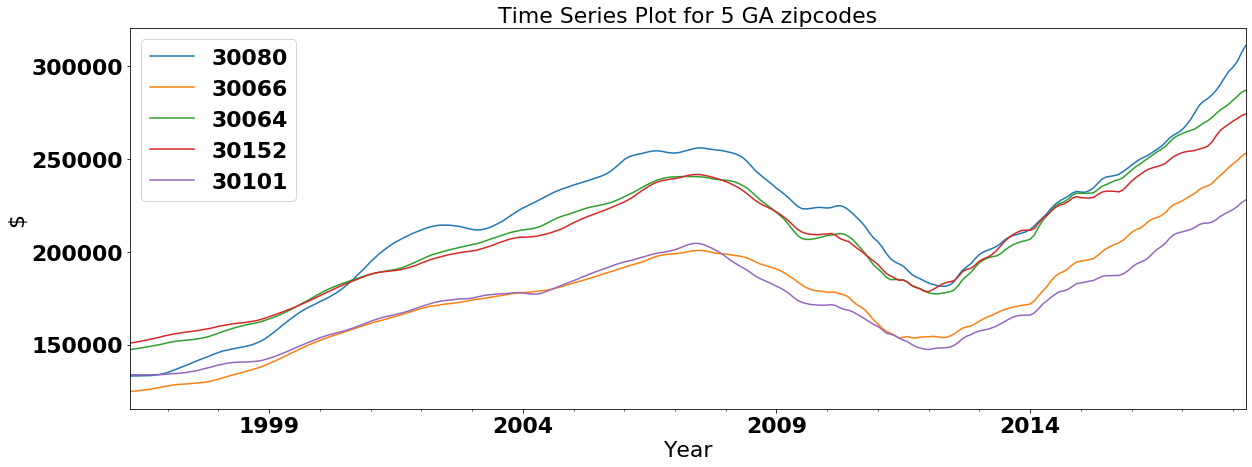

In [55]:
for i in range(5):
    ts[i].value.plot(label=ts[i].RegionName[0],figsize=(20,7),legend=True)
    plt.legend
    plt.title("Time Series Plot for 5 GA zipcodes",{'size':22});
    plt.xlabel("Year",{'size':22})
    plt.ylabel("$",{'size':22})

In [56]:
# I can see an overall positive trend year to year, but I want to dig a little deeper and look month to month
# Let's compare the top5 zipcodes by monthly returns.
# "mr" = monthly returns
for z in range(len(ts)):
    ts[z]['mr']=np.nan*len(ts[z])
    for i in range(len(ts[z])-1):
        ts[z]['mr'][i+1] = (ts[z].value.iloc[i+1] / ts[z].value.iloc[i]) -1

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


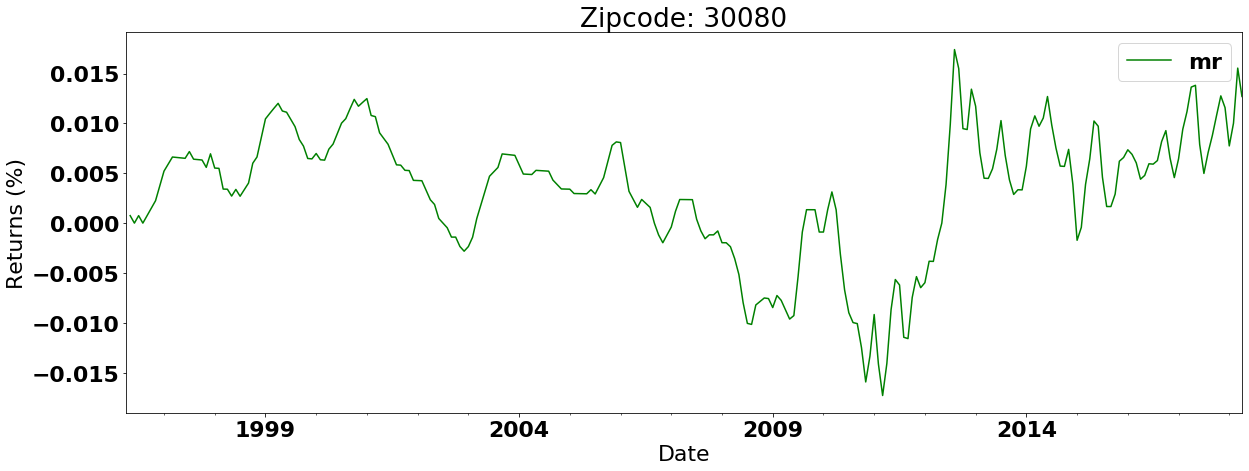

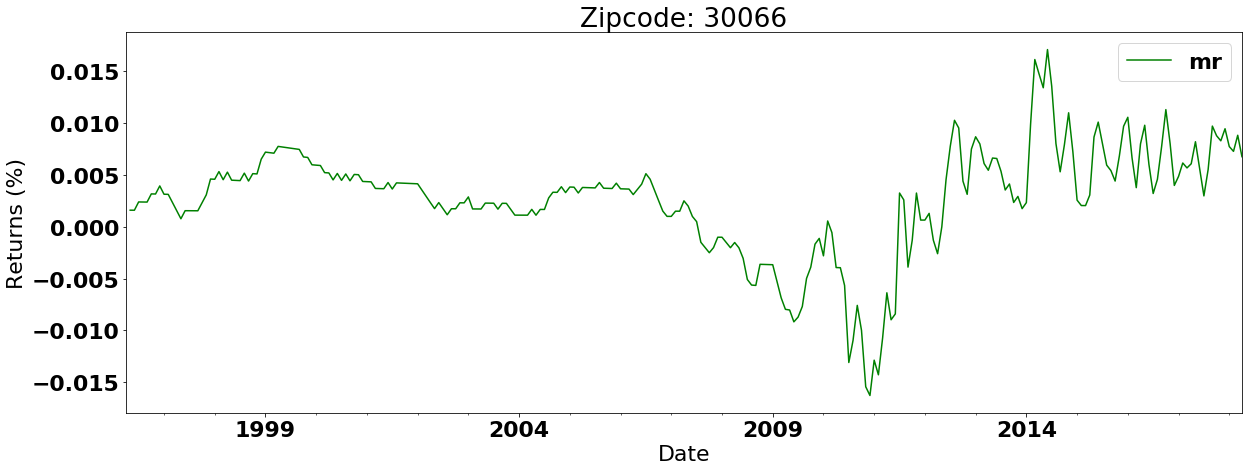

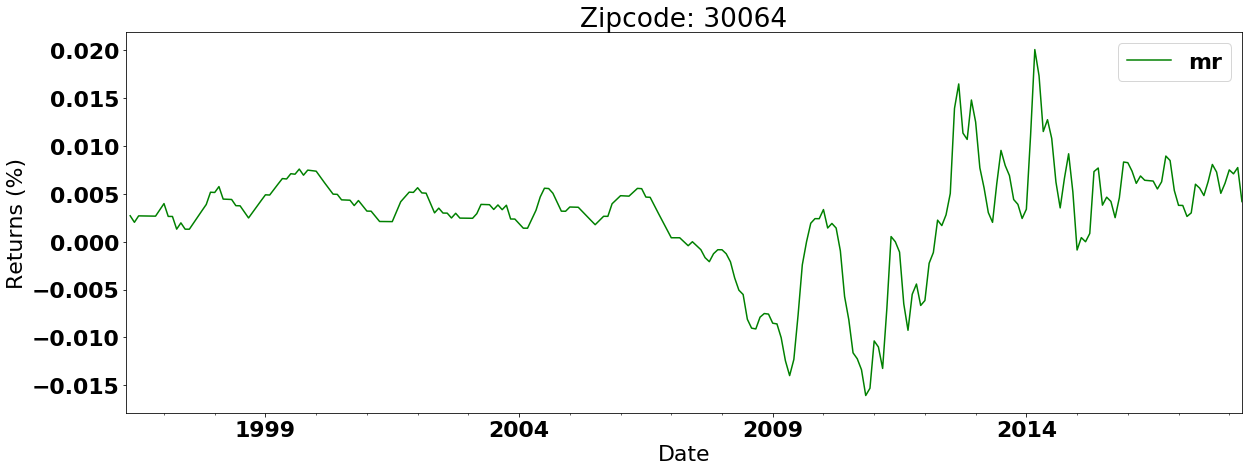

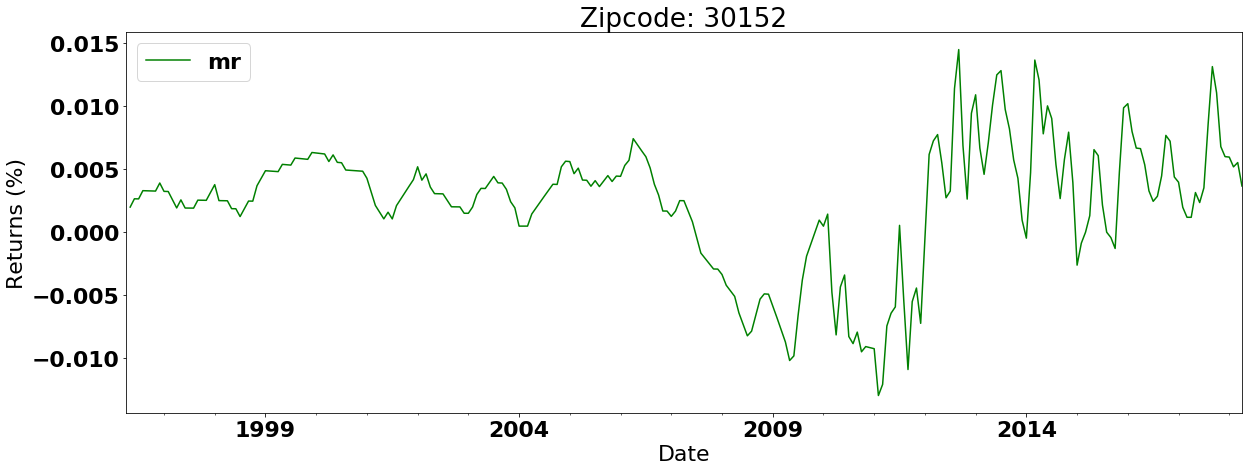

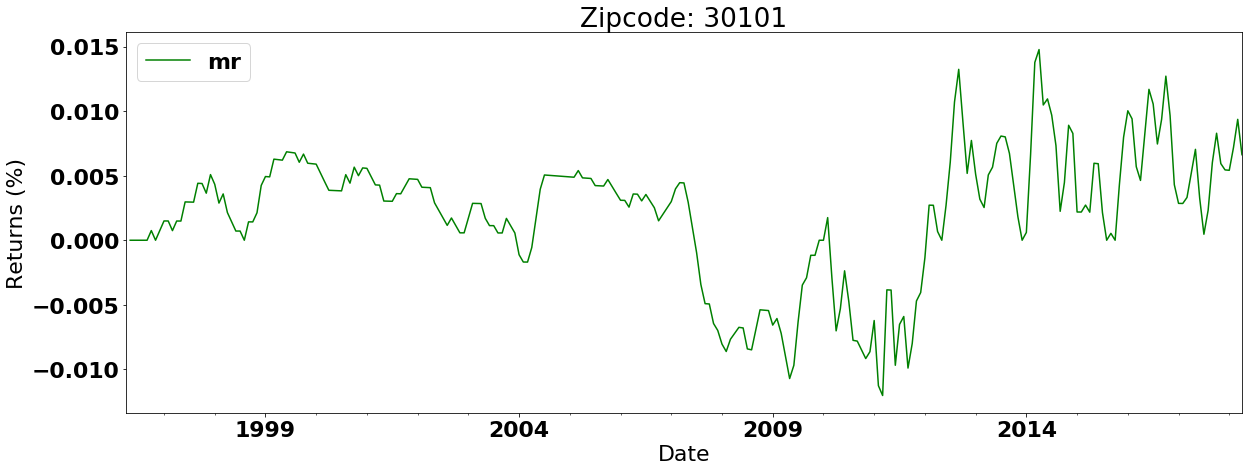

In [57]:
for i in range(len(ts)):
    ts[i].mr.plot(figsize=(20,7), color = 'g')
    plt.title(f'Zipcode: {ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()

# Step 2: Data Preprocessing

In [58]:
# Rolling Mean

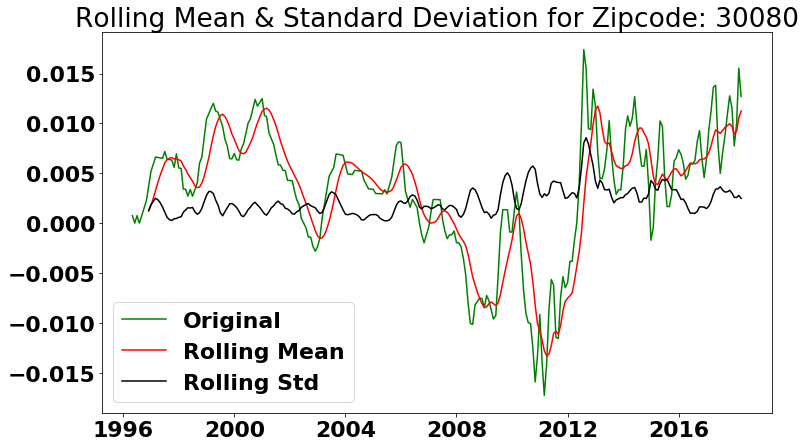

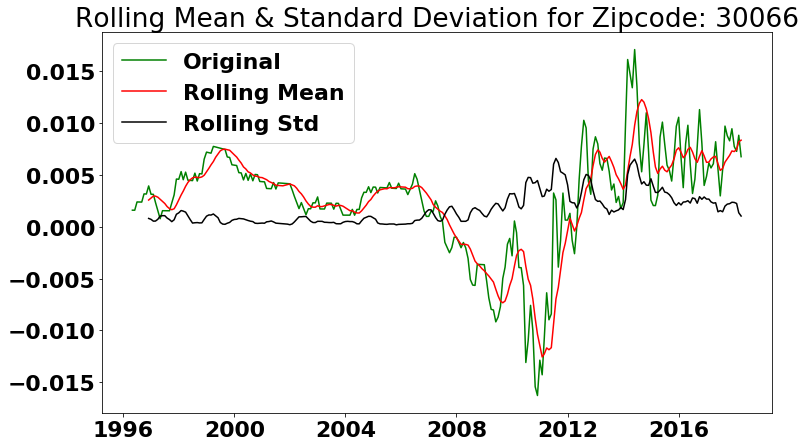

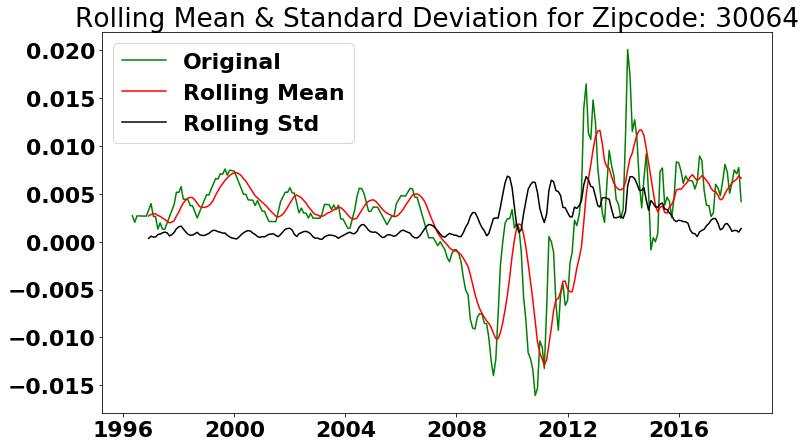

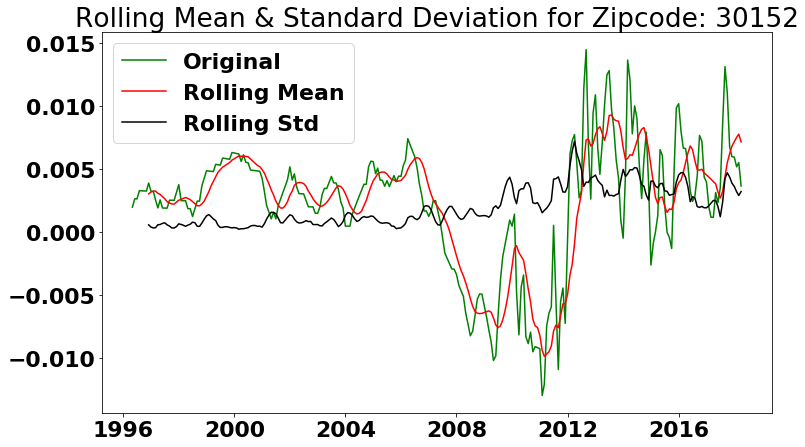

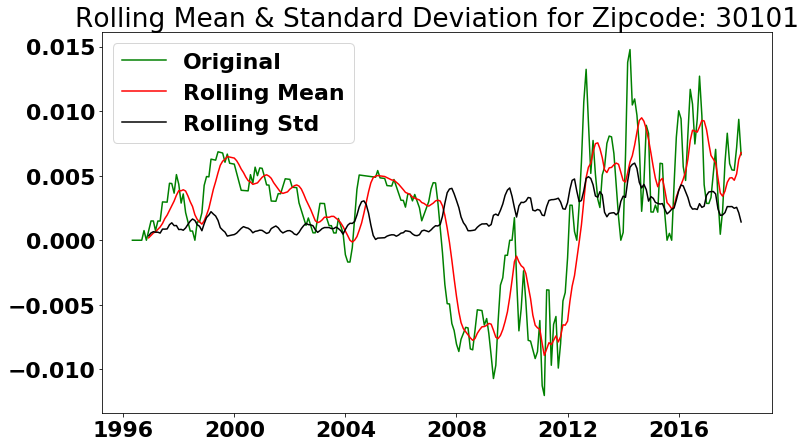

In [59]:
for i in range(len(ts)):
    roll_mean = ts[i].mr.rolling(window=8, center=False).mean()
    roll_std = ts[i].mr.rolling(window=8, center=False).std()
    
    fig = plt.figure(figsize=(12,7))
    orig = plt.plot(ts[i].mr, color='green',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {ts[i].RegionName[0]}')
    plt.show()

### Dickey-Fuller Test - Test stationarity
##### h0 = time series is NOT stationary
##### *** if p-value <0.05, we reject the null-hypothesis
https://machinelearningmastery.com/time-series-data-stationary-python/

In [60]:
for i in range(5):
    dftest = adfuller(ts[i].mr.dropna())
    print(f'ADFuller test p-value for zipcode: {ts[i].RegionName[0]}')
    print('p-value:',dftest[1])
    if dftest[1]>0.05:
        print('We fail to reject the null hypothesis H0. The data is NOT stationary.\n')
    else:
        print('We reject the null hypothesis H0. The data is stationary.\n')

ADFuller test p-value for zipcode: 30080
p-value: 0.10582668020507491
We fail to reject the null hypothesis H0. The data is NOT stationary.

ADFuller test p-value for zipcode: 30066
p-value: 0.40135495914414054
We fail to reject the null hypothesis H0. The data is NOT stationary.

ADFuller test p-value for zipcode: 30064
p-value: 0.43644912328630764
We fail to reject the null hypothesis H0. The data is NOT stationary.

ADFuller test p-value for zipcode: 30152
p-value: 0.08962915917599712
We fail to reject the null hypothesis H0. The data is NOT stationary.

ADFuller test p-value for zipcode: 30101
p-value: 0.1848218706788976
We fail to reject the null hypothesis H0. The data is NOT stationary.



In [61]:
# Naked eye test tells us that the data looks stationary.
# Let's take the first difference of the zipcodes to check for stationarity.

In [62]:
for i in [0,1,2,3,4]:
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    dftest = adfuller(ts[i].mr.diff().dropna())
    print(f'ADFuller test p-value for zipcode: {ts[i].RegionName[0]}')
    print('p-value:',dftest[1])
    if dftest[1]>0.05:
        print('We fail to reject the null hypothesis H0. Data is Non-stationary.\n')
    else:
        print('We reject the null hypothesis H0. Data is stationary.\n')

ADFuller test p-value for zipcode: 30080
p-value: 7.5012888900277046e-06
We reject the null hypothesis H0. Data is stationary.

ADFuller test p-value for zipcode: 30066
p-value: 1.6411543749960408e-06
We reject the null hypothesis H0. Data is stationary.

ADFuller test p-value for zipcode: 30064
p-value: 7.68917318547343e-13
We reject the null hypothesis H0. Data is stationary.

ADFuller test p-value for zipcode: 30152
p-value: 0.00016896829541302393
We reject the null hypothesis H0. Data is stationary.

ADFuller test p-value for zipcode: 30101
p-value: 9.757571224626924e-11
We reject the null hypothesis H0. Data is stationary.



In [63]:
# "i" is most likely 1 since the data was not already stationary
# if data was stationary, "i" would have been 0

In [64]:
ts_30080 = ts[0].mr.dropna() #Zipcode 30080 monthly returns time series
ts_30080_diff = ts[0].mr.diff().dropna() #Zipcode 30080 monthly returns differenced time series

ts_30066 = ts[1].mr.dropna() #Zipcode 30066 monthly returns time series
ts_30066_diff = ts[1].mr.diff().dropna() #Zipcode 30066 monthly returns differenced time series

ts_30064 = ts[2].mr.dropna() #Zipcode 30064 monthly returns time series
ts_30064_diff = ts[2].mr.diff().dropna() #Zipcode 30064 monthly returns differenced time series

ts_30152 = ts[3].mr.dropna() #Zipcode 30152 monthly returns time series
ts_30152_diff = ts[3].mr.diff().dropna() #Zipcode 30152 monthly returns differenced time series

ts_30101 = ts[4].mr.dropna() #Zipcode 30101 monthly returns time series
ts_30101_diff = ts[4].mr.diff().dropna() #Zipcode 30101 monthly returns differenced time series


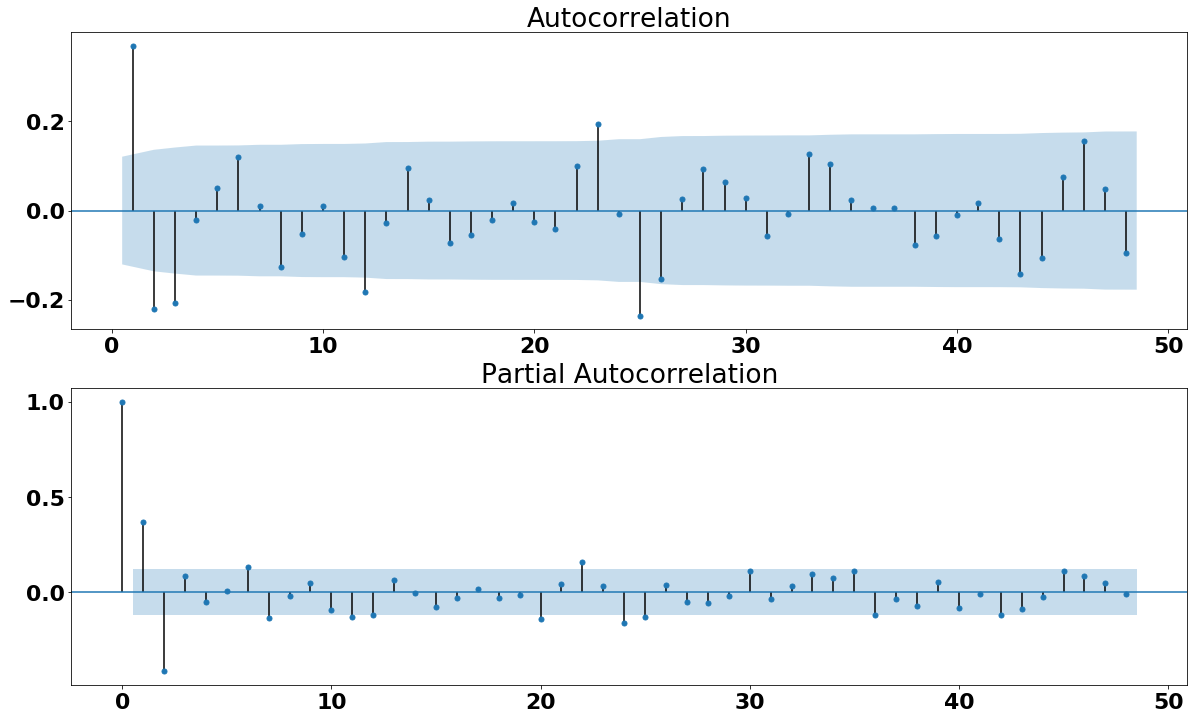

In [65]:
acf_pacf(ts_30080_diff)

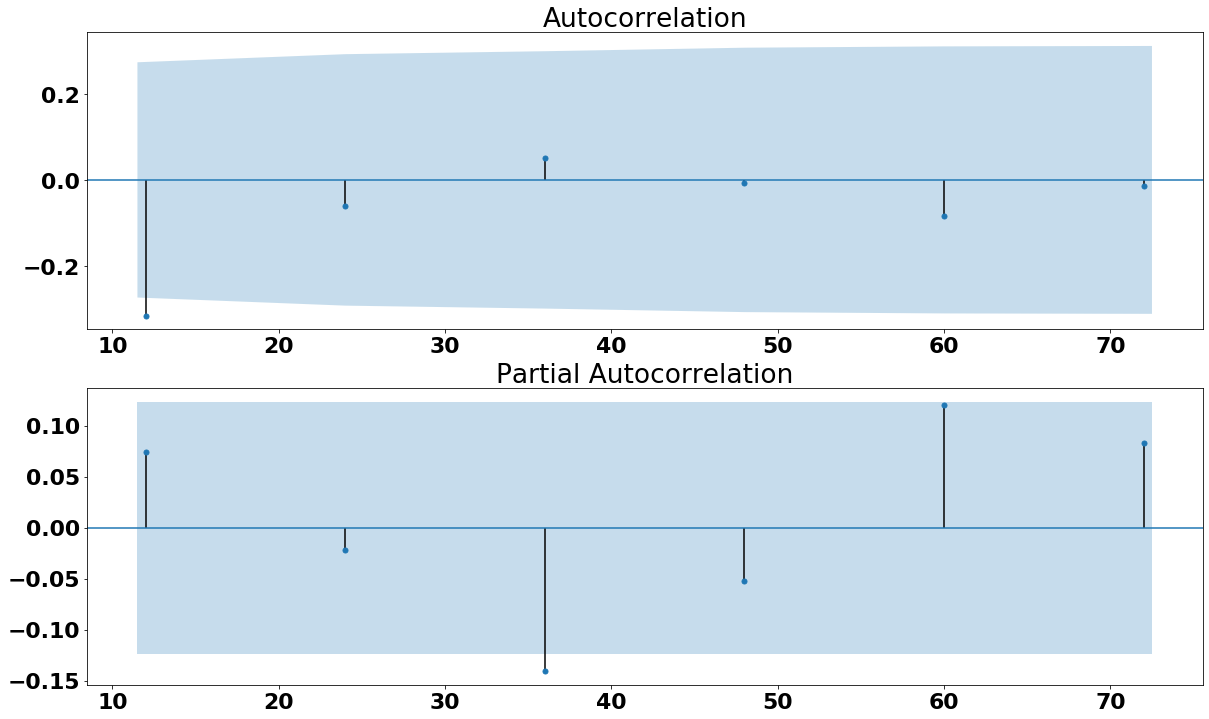

In [66]:
seasonal_plots(ts_30080_diff, N=13)

In [67]:
dftest = pm.auto_arima(ts_30080_diff,information_criterion='aic',m=12,d=1,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
dftest

#d=0 if data was originally non-stationary
#d=1 if data was stationary after we took difference

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-2596.038, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2463.633, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2469.617, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2471.004, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-2465.628, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-2599.114, Time=0.67 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-2592.354, Time=0.35 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-2596.877, Time=1.10 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-2598.359, Time=0.46 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-2593.711, Time=2.04 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-2558.321, Time=0.66 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-2564.060, Time=0.35 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=-2461.897, Time=0.24 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-2600.408, Time=0.64 sec
 ARIM

ARIMA(order=(0, 1, 4), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                   mr   No. Observations:                  228
Model:             SARIMAX(0, 1, 4)x(0, 0, [1], 12)   Log Likelihood                1157.158
Date:                              Thu, 10 Sep 2020   AIC                          -2302.317
Time:                                      12:42:27   BIC                          -2281.767
Sample:                                  05-01-1996   HQIC                         -2294.025
                                       - 04-01-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6248      0.050     12.374      0.000       0.526       0.724
ma.L2         -0.07

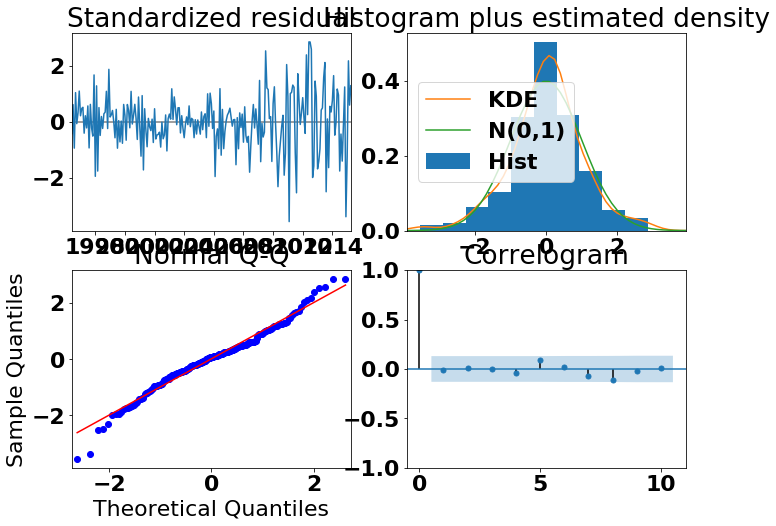

In [68]:
# SARIMA model parameters
# p = 0 d = 1 q = 4
# P = 0 D = 0 Q = 1 S = 12

# Fit SARIMA model
pdq = (0,1,4)
pdqs = (0,0,1,12)
train, test, results = model_fit(ts_30080,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00228


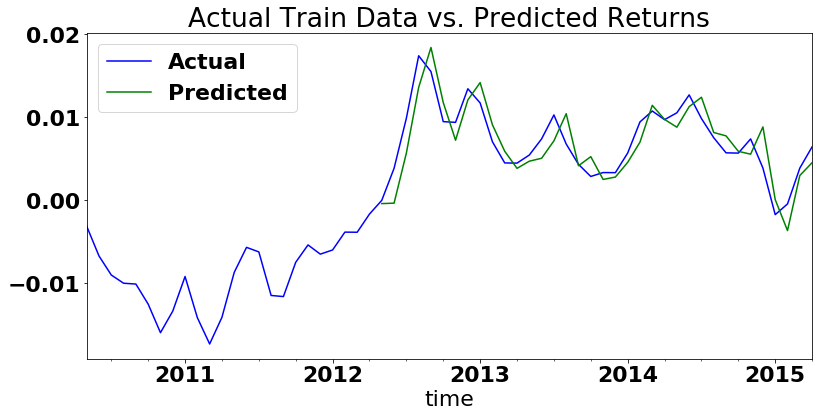

In [69]:
train_RMSE(train, results)

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anacond

SARIMA model RMSE on test data: 0.00207


/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


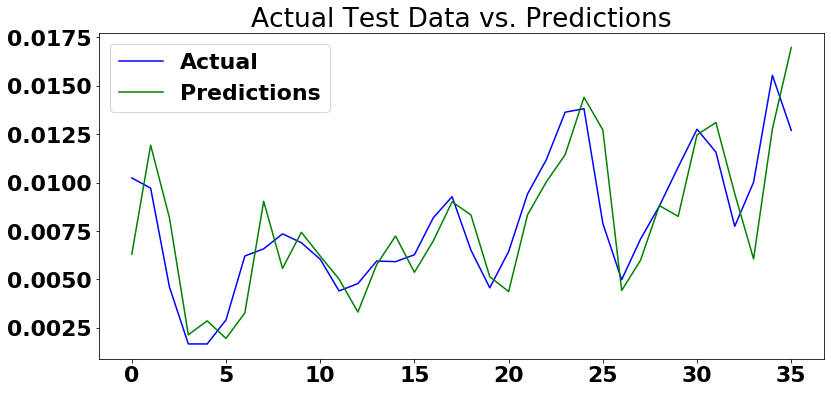

In [70]:
test_RMSE(ts_30080,pdq=pdq,pdqs=pdqs, display=True)

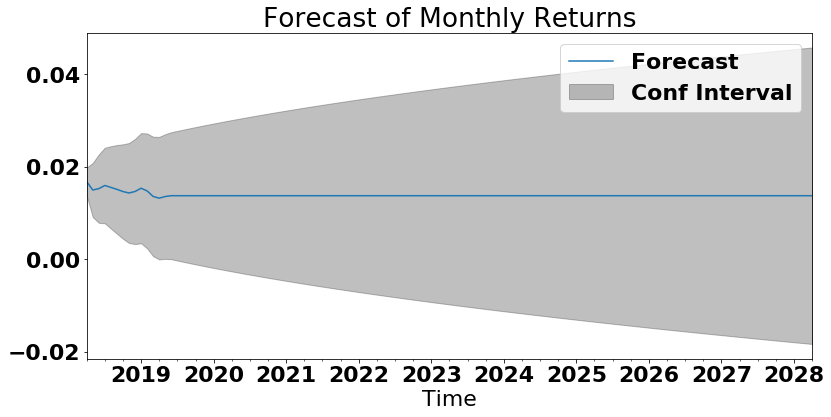

Expected 1yr return: 19.71%
Expected 3yr return: 66.07%
Expected 5yr return: 130.53%
Expected 10yr return: 430.63%


In [71]:
mr_30080=forecast_model(ts_30080,pdq=pdq,pdqs=pdqs, z=30080)

In [72]:
# Zipcode 2: 30066

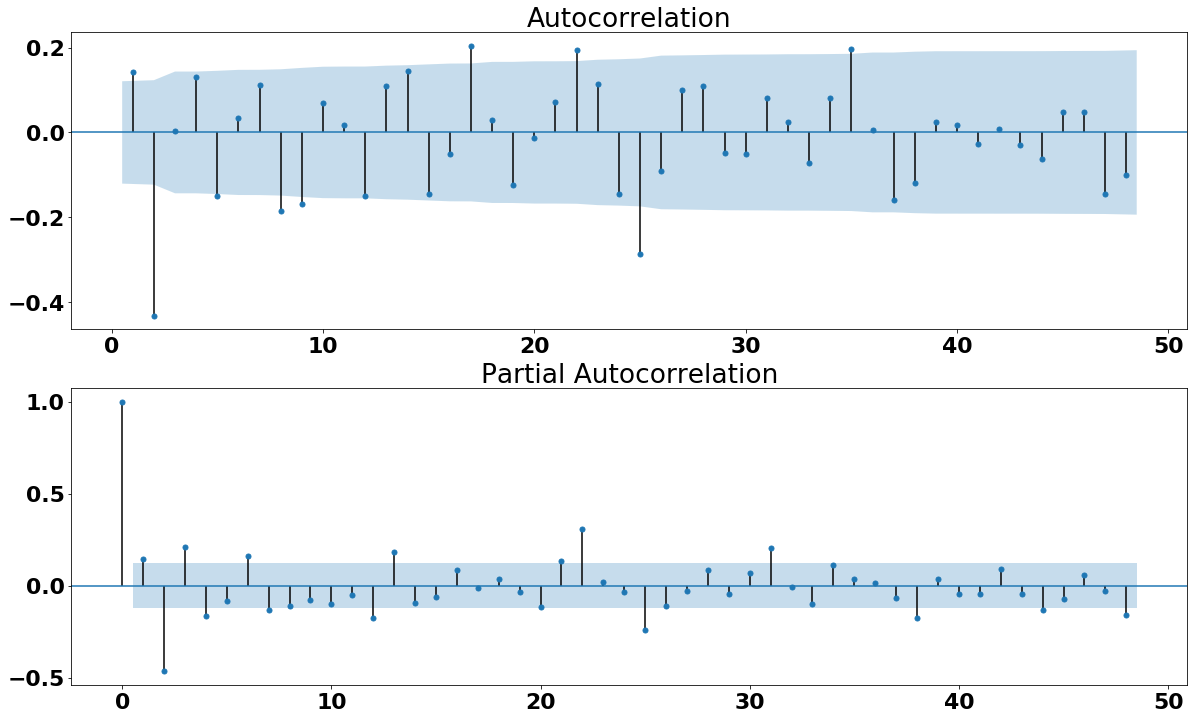

In [73]:
acf_pacf(ts_30066_diff)

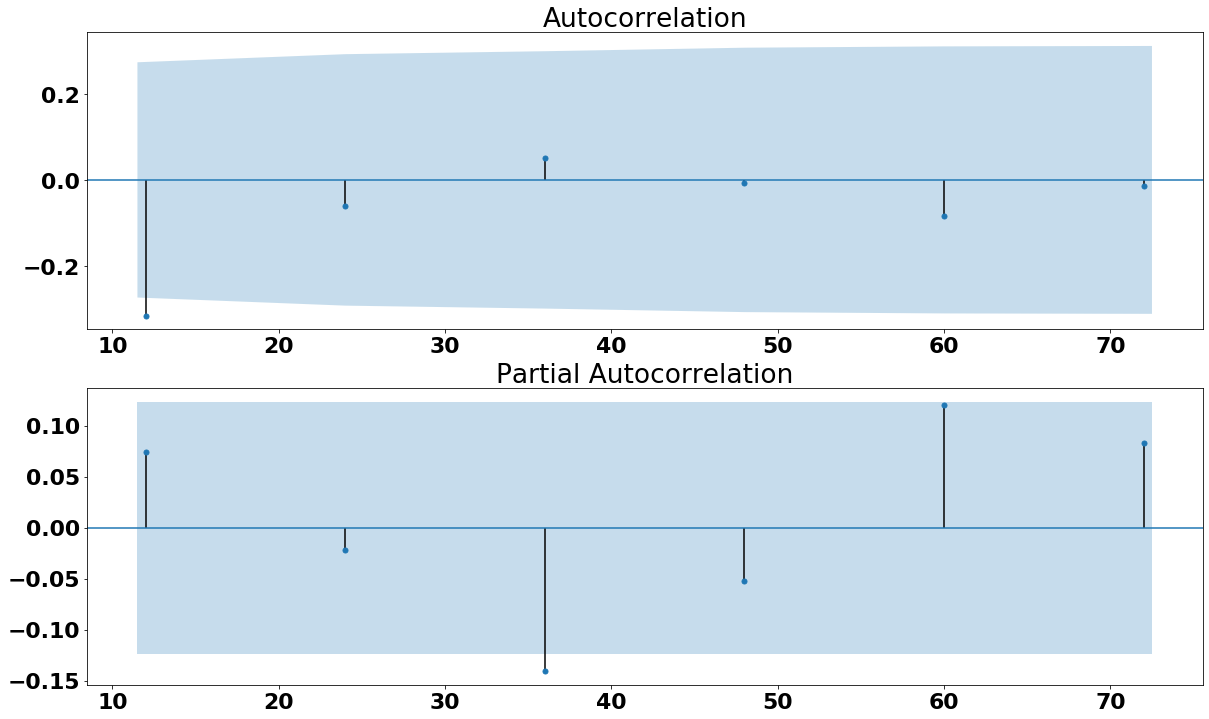

In [74]:
seasonal_plots(ts_30066_diff, N=13)

In [75]:
dftest = pm.auto_arima(ts_30066_diff,information_criterion='aic',m=12,d=1,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
dftest

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-2541.858, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2367.507, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2384.674, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2417.312, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-2369.503, Time=0.06 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-2549.442, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-2547.015, Time=0.28 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-2542.836, Time=1.73 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-2547.948, Time=0.33 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-2538.396, Time=1.57 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-2387.882, Time=0.60 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-2508.219, Time=0.24 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=-2380.356, Time=0.30 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-2567.460, Time=0.88 sec
 ARIM

ARIMA(order=(1, 1, 5), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

                                        SARIMAX Results                                        
Dep. Variable:                                      mr   No. Observations:                  228
Model:             SARIMAX(1, 1, 5)x(0, 0, [1, 2], 12)   Log Likelihood                1136.159
Date:                                 Thu, 10 Sep 2020   AIC                          -2254.317
Time:                                         12:43:28   BIC                          -2223.492
Sample:                                     05-01-1996   HQIC                         -2241.879
                                          - 04-01-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0631      0.464      0.136      0.892      -0.846       0

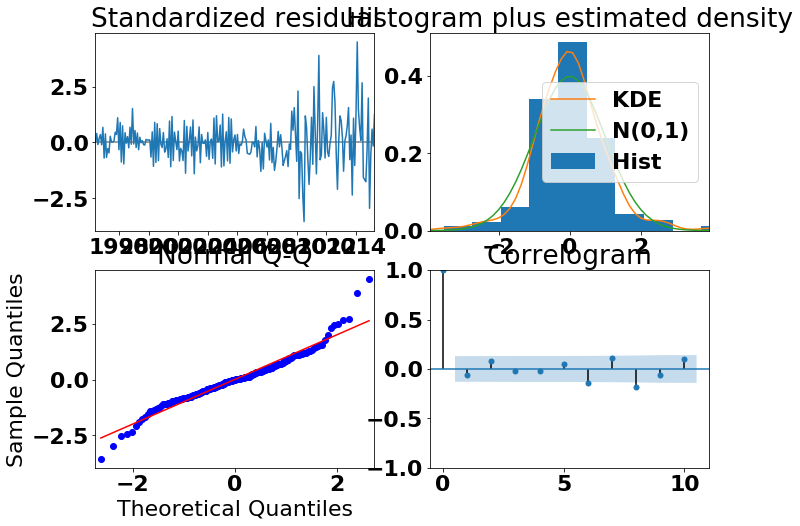

In [76]:
# SARIMA model parameters
# p = 1 d = 1 q = 5
# P = 0 D = 0 Q = 2 S = 12

# Fit SARIMA model
pdq = (1,1,5)
pdqs = (0,0,2,12)
train, test, results = model_fit(ts_30066,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00256


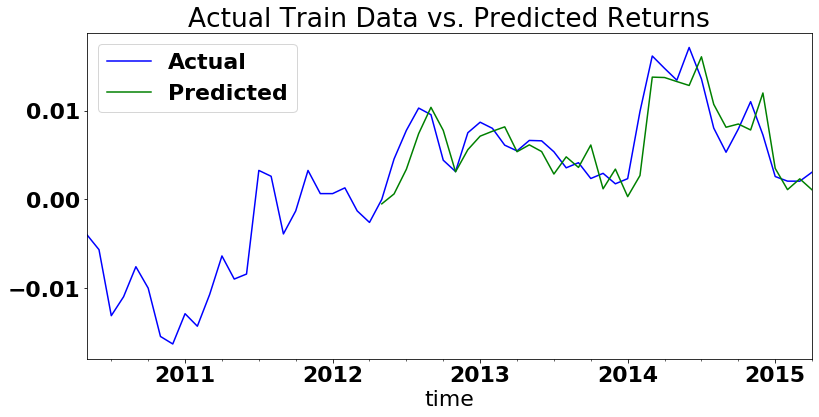

In [77]:
train_RMSE(train, results)

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anacond

SARIMA model RMSE on test data: 0.00201


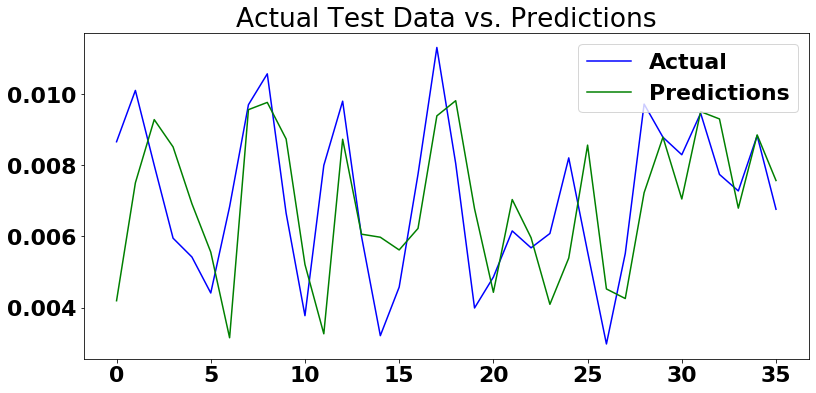

In [78]:
test_RMSE(ts_30066,pdq=pdq,pdqs=pdqs, display=True)

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


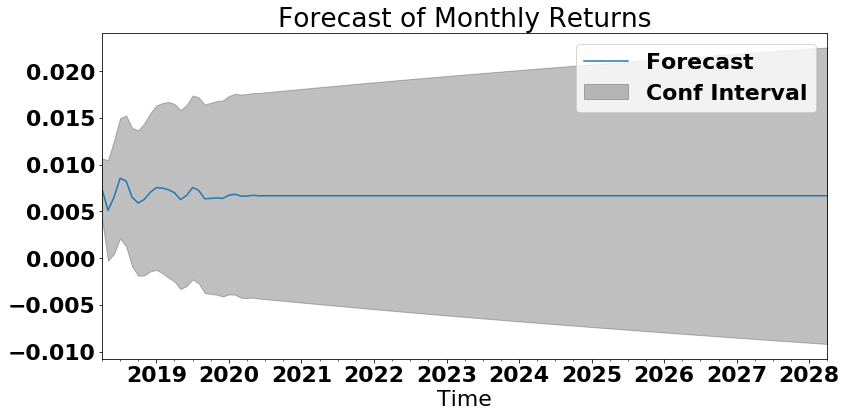

Expected 1yr return: 8.71%
Expected 3yr return: 27.57%
Expected 5yr return: 49.64%
Expected 10yr return: 124.47%


In [79]:
mr_30066=forecast_model(ts_30066,pdq=pdq,pdqs=pdqs, z=30066)

In [80]:
# Zipcode 3: 30064

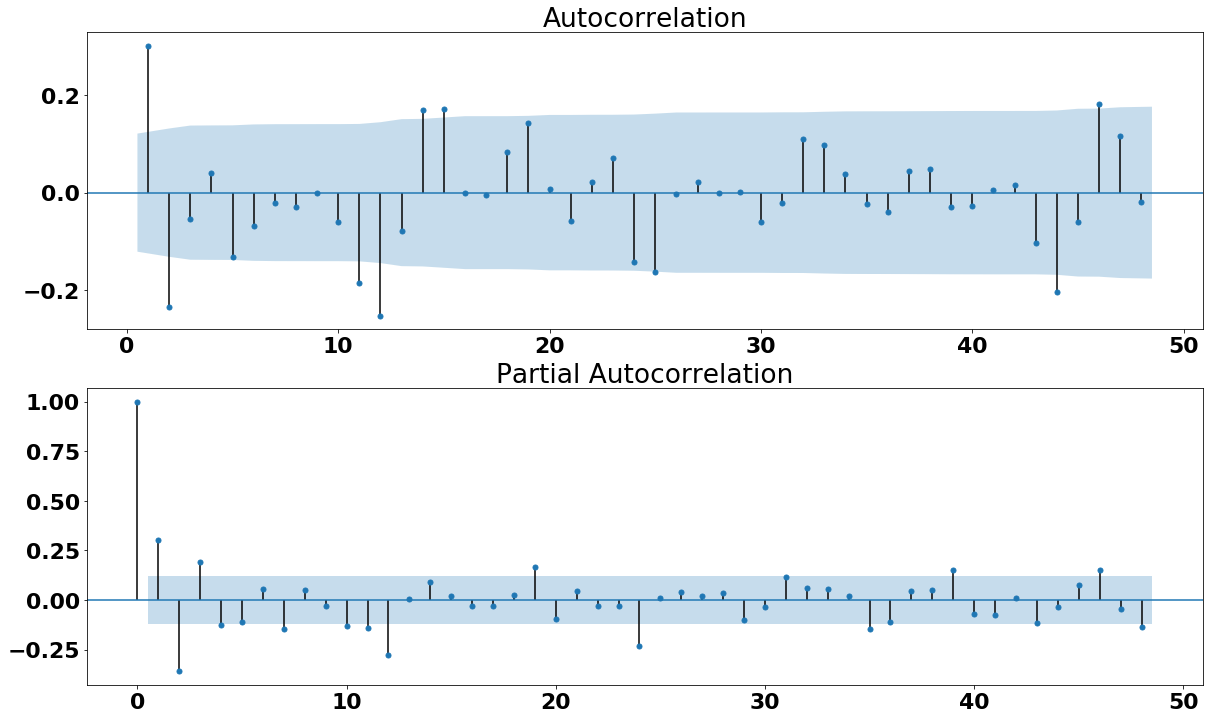

In [81]:
acf_pacf(ts_30064_diff)

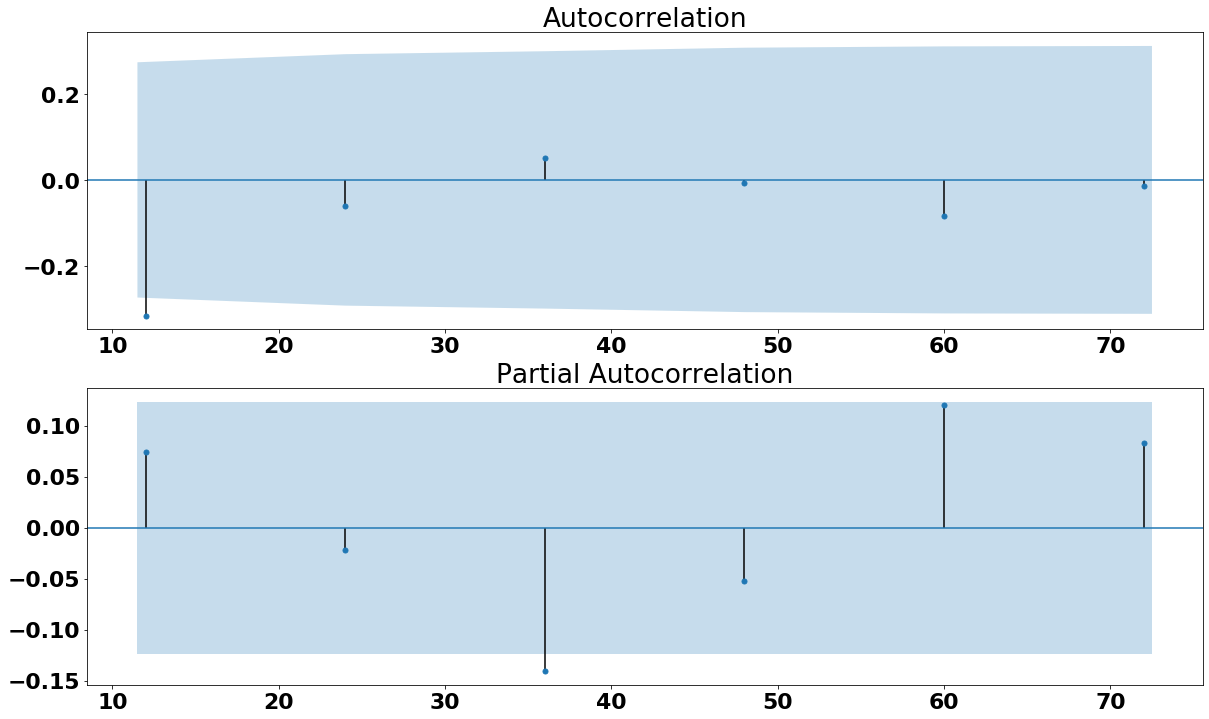

In [82]:
seasonal_plots(ts_30064_diff, N=13)

In [83]:
dftest = pm.auto_arima(ts_30064_diff,information_criterion='aic',m=12,d=1,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
dftest

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-2538.505, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2421.012, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2430.094, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2447.178, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-2423.005, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-2544.491, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-2531.423, Time=0.22 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-2559.678, Time=0.86 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-2553.047, Time=2.77 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=-2567.069, Time=1.64 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-2551.738, Time=0.57 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=-2561.283, Time=1.70 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-2545.790, Time=0.57 sec
 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=-2572.329, Time=1.11 sec
 ARIM

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

                                        SARIMAX Results                                        
Dep. Variable:                                      mr   No. Observations:                  228
Model:             SARIMAX(0, 1, 3)x(0, 0, [1, 2], 12)   Log Likelihood                1130.801
Date:                                 Thu, 10 Sep 2020   AIC                          -2249.602
Time:                                         12:44:30   BIC                          -2229.052
Sample:                                     05-01-1996   HQIC                         -2241.310
                                          - 04-01-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5349      0.062      8.671      0.000       0.414       0

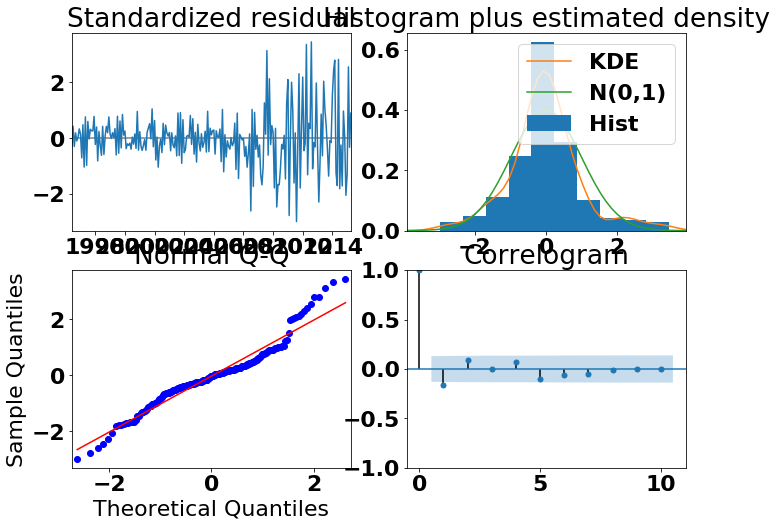

In [84]:
# SARIMA model parameters
# p = 0 d = 1 q = 3
# P = 0 D = 0 Q = 2 S = 12

# Fit SARIMA model
pdq = (0,1,3)
pdqs = (0,0,2,12)
train, test, results = model_fit(ts_30064,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00242


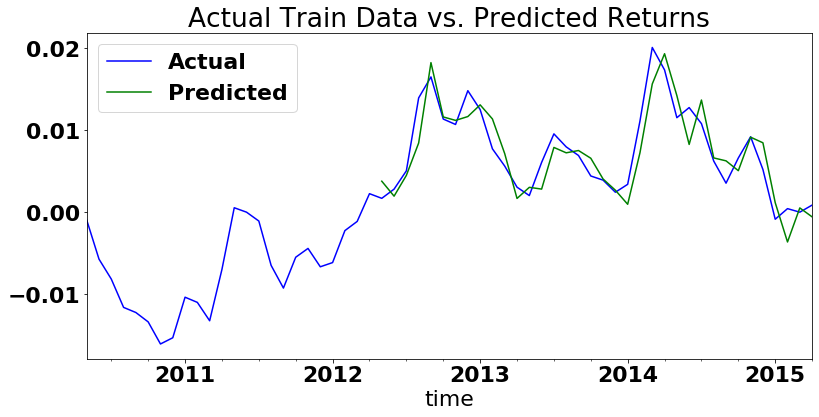

In [85]:
train_RMSE(train, results)

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anacond

SARIMA model RMSE on test data: 0.00196


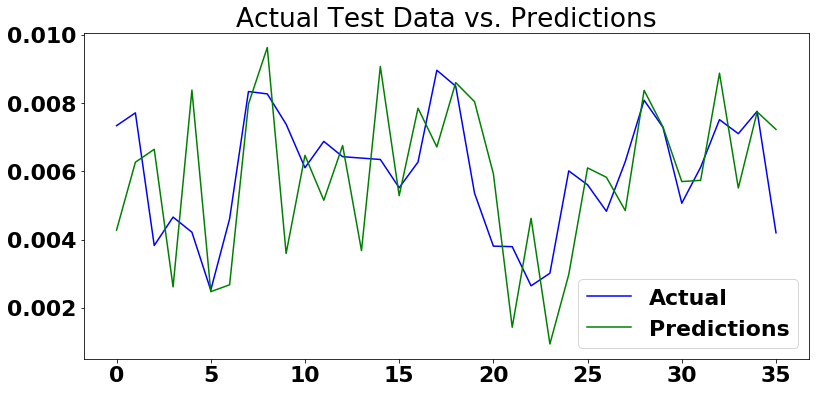

In [86]:
test_RMSE(ts_30064,pdq=pdq,pdqs=pdqs, display=True)

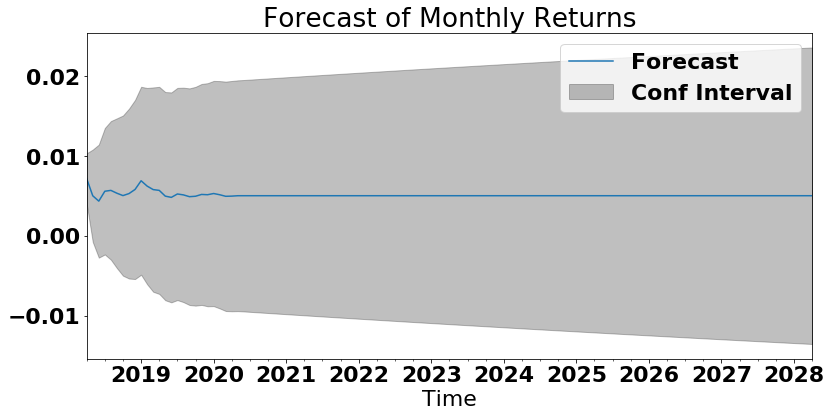

Expected 1yr return: 7.06%
Expected 3yr return: 20.91%
Expected 5yr return: 36.41%
Expected 10yr return: 85.34%


In [87]:
mr_30064=forecast_model(ts_30064,pdq=pdq,pdqs=pdqs, z=30064)

In [88]:
#Zipcode 4: 30152

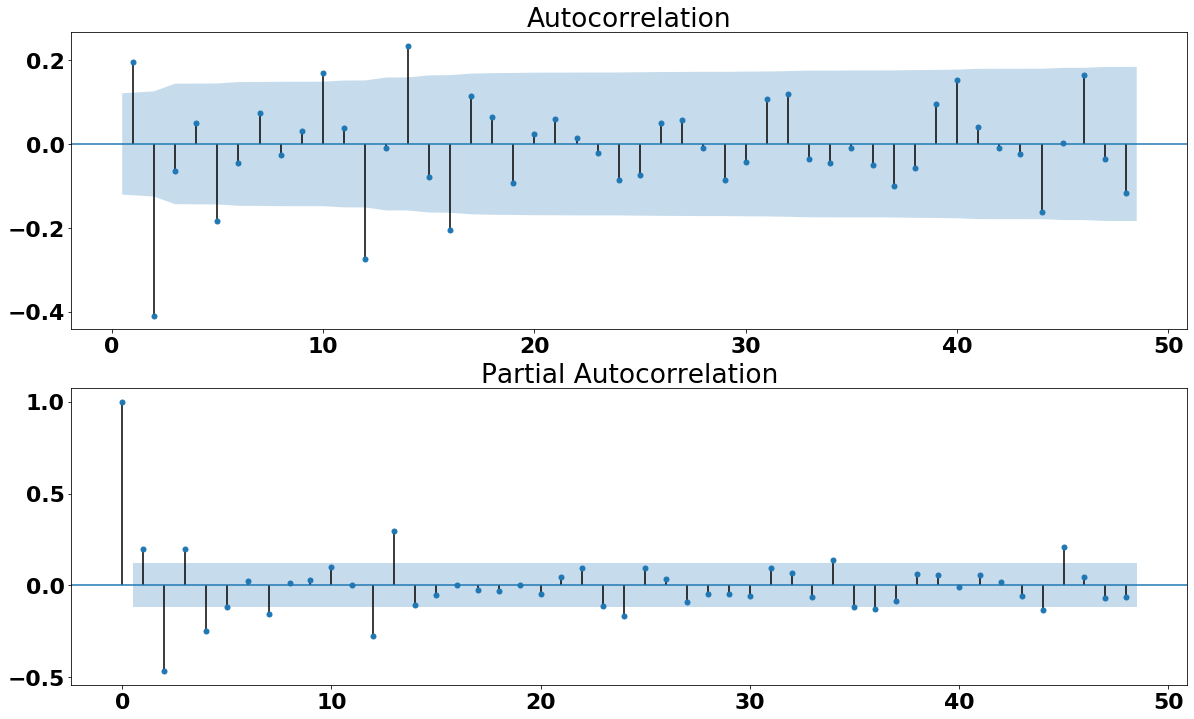

In [89]:
acf_pacf(ts_30152_diff)

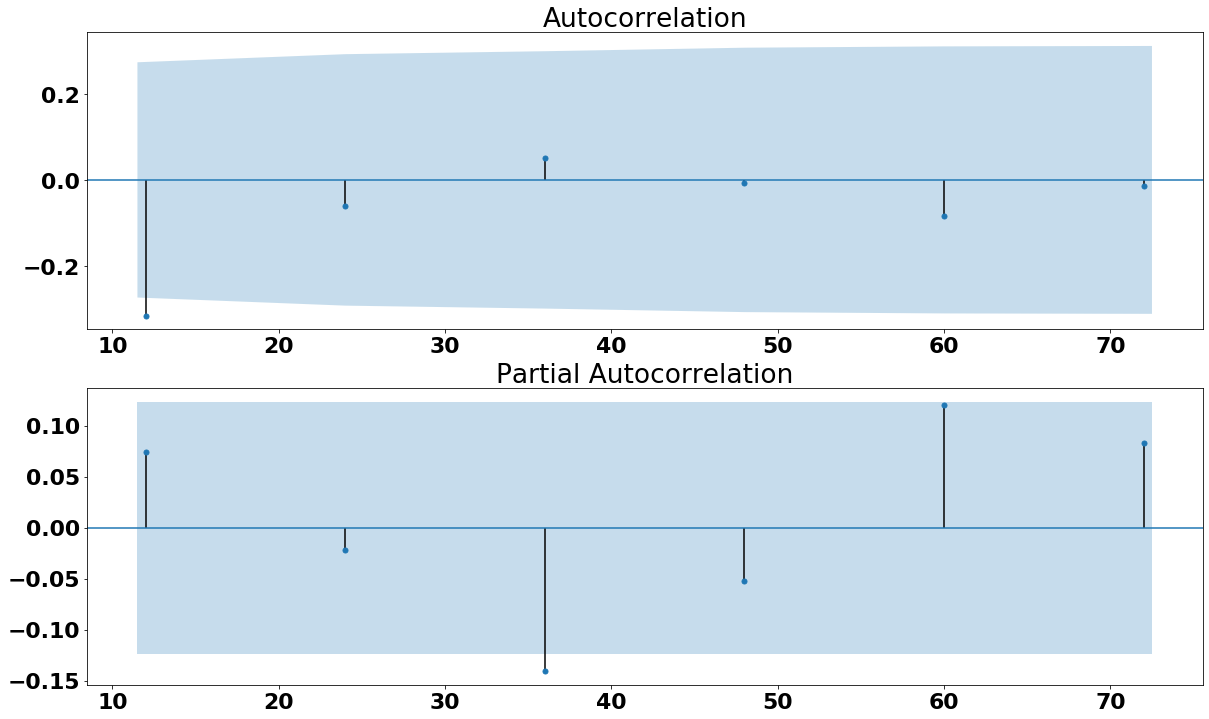

In [90]:
seasonal_plots(ts_30152_diff, N=13)

In [91]:
dftest = pm.auto_arima(ts_30152_diff,information_criterion='aic',m=12,d=1,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
dftest

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-2527.236, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2347.654, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2383.817, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2417.882, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-2349.649, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-2543.416, Time=0.53 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-2511.737, Time=0.17 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-2546.698, Time=0.87 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-2542.022, Time=0.83 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=-2408.069, Time=0.64 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=-2505.910, Time=1.76 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=-2400.444, Time=1.47 sec
 ARIMA(2,1,3)(0,0,2)[12] intercept   : AIC=-2582.300, Time=3.71 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-2572.761, Time=0.76 sec
 ARIM

ARIMA(order=(1, 1, 4), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

                                        SARIMAX Results                                        
Dep. Variable:                                      mr   No. Observations:                  228
Model:             SARIMAX(1, 1, 4)x(0, 0, [1, 2], 12)   Log Likelihood                1130.907
Date:                                 Thu, 10 Sep 2020   AIC                          -2245.814
Time:                                         12:45:35   BIC                          -2218.414
Sample:                                     05-01-1996   HQIC                         -2234.758
                                          - 04-01-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0279      0.313     -0.089      0.929      -0.641       0

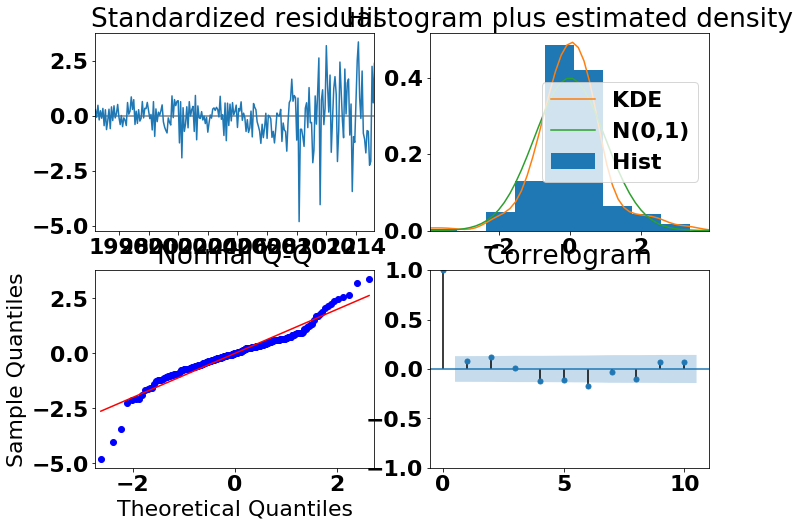

In [92]:
# SARIMA model parameters
# p = 1 d = 1 q = 4
# P = 0 D = 0 Q = 2 S = 12

# Fit SARIMA model
pdq = (1,1,4)
pdqs = (0,0,2,12)
train, test, results = model_fit(ts_30152,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00264


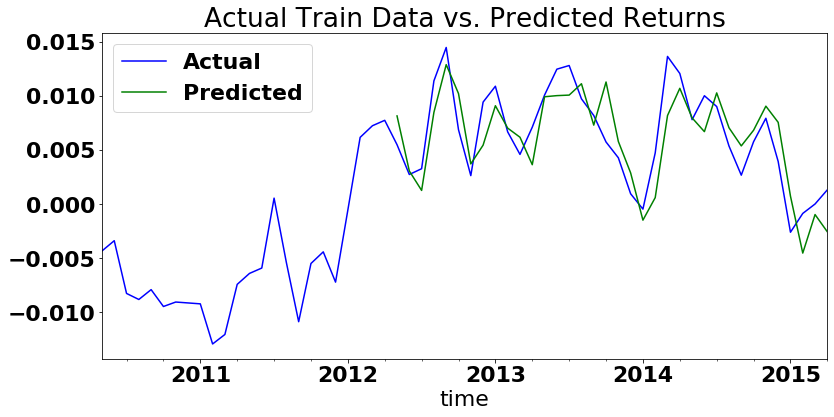

In [93]:
train_RMSE(train, results)

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anacond

SARIMA model RMSE on test data: 0.00193


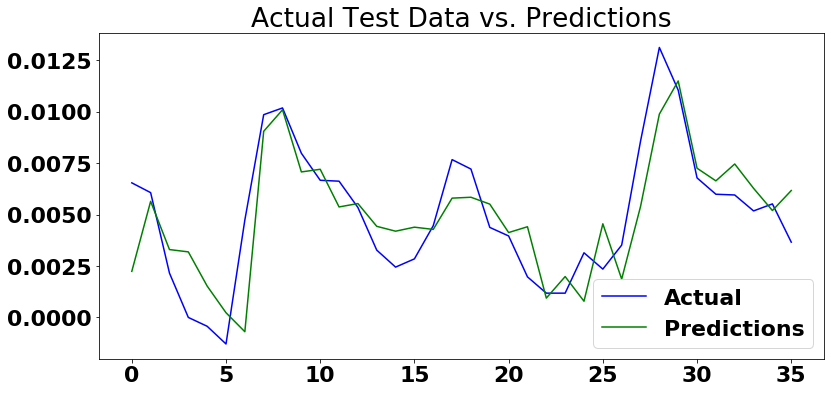

In [94]:
test_RMSE(ts_30152,pdq=pdq,pdqs=pdqs, display=True)

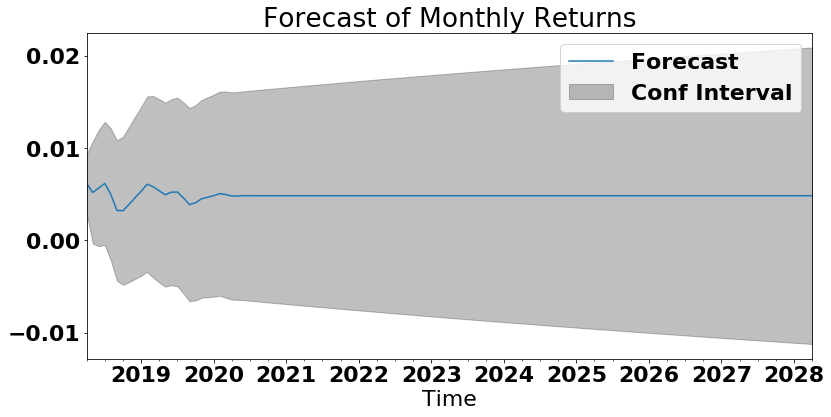

Expected 1yr return: 6.19%
Expected 3yr return: 19.12%
Expected 5yr return: 33.72%
Expected 10yr return: 79.4%


In [95]:
mr_30152=forecast_model(ts_30152,pdq=pdq,pdqs=pdqs, z=30152)

In [96]:
# Zipcode 5: 30101

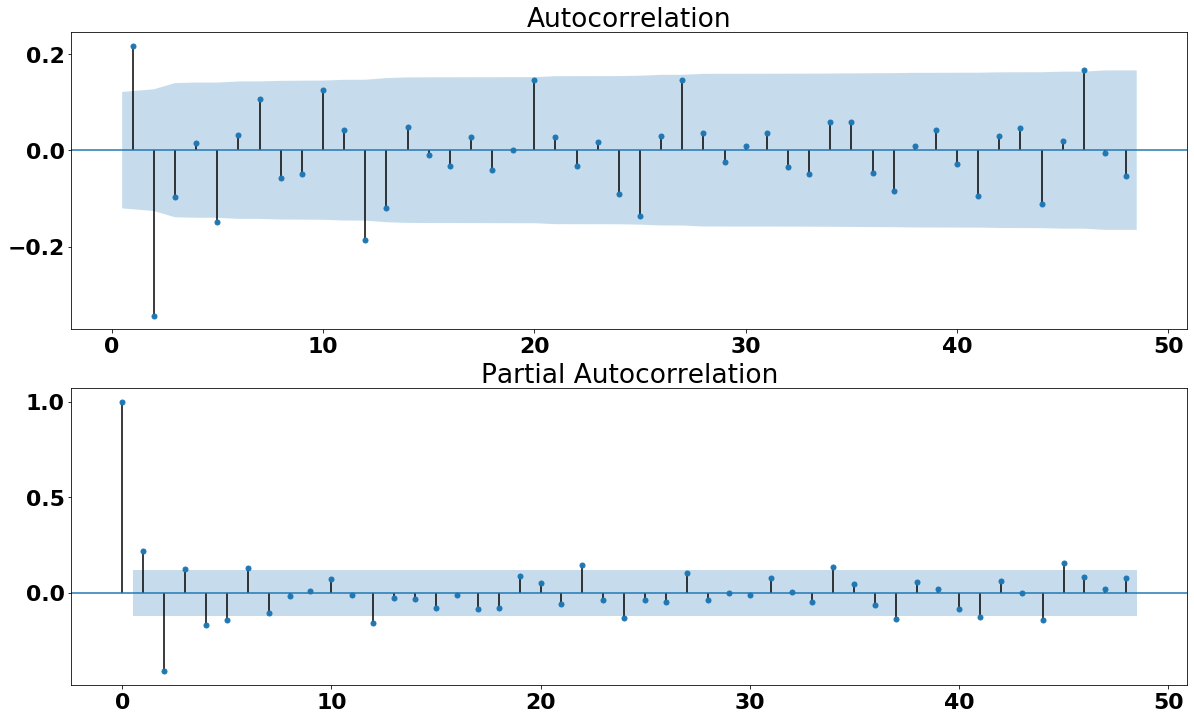

In [97]:
acf_pacf(ts_30101_diff)

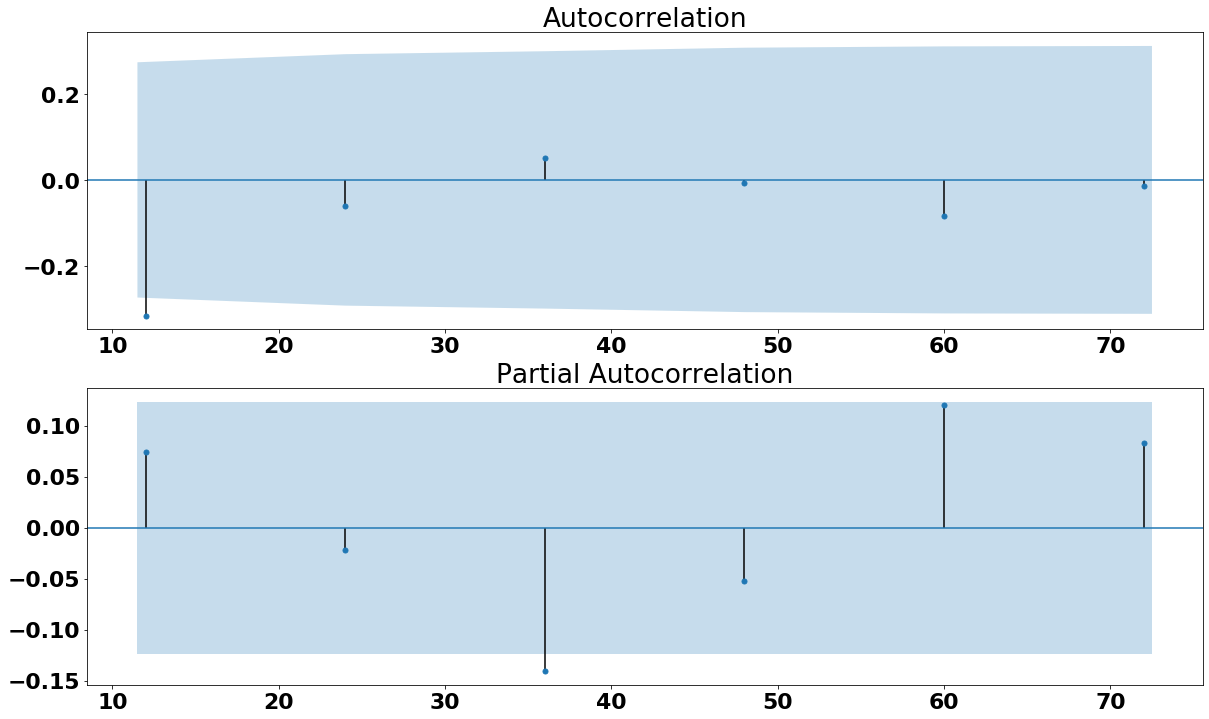

In [98]:
seasonal_plots(ts_30101_diff, N=13)

In [99]:
dftest = pm.auto_arima(ts_30101_diff,information_criterion='aic',m=12,d=1,stepwise=True,trace=True,
                        error_action='ignore',suppress_warnings=True)
dftest

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-2550.504, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-2409.350, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2420.284, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-2441.357, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-2411.343, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-2555.104, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-2551.619, Time=0.31 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-2531.861, Time=2.15 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-2554.736, Time=0.56 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-2530.253, Time=2.31 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-2417.723, Time=0.46 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-2515.835, Time=0.29 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=-2535.045, Time=0.84 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-2581.989, Time=1.15 sec
 ARIM

ARIMA(order=(1, 1, 4), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                      SARIMAX Results                                      
Dep. Variable:                                  mr   No. Observations:                  228
Model:             SARIMAX(1, 1, 4)x(2, 0, [], 12)   Log Likelihood                1143.769
Date:                             Thu, 10 Sep 2020   AIC                          -2271.538
Time:                                     12:46:46   BIC                          -2244.138
Sample:                                 05-01-1996   HQIC                         -2260.482
                                      - 04-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0677      0.420     -0.161      0.872      -0.892       0.756
ma.L1          0.4518      

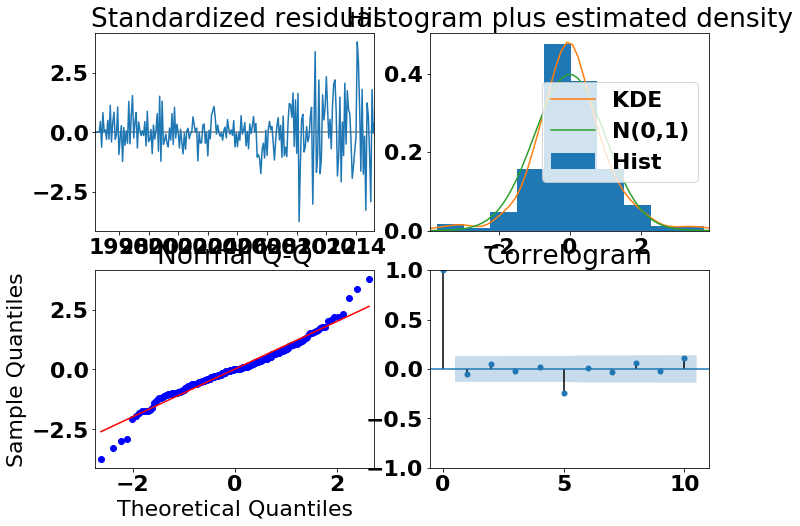

In [100]:
# SARIMA model parameters
# p = 1 d = 1 q = 4
# P = 2 D = 0 Q = 0 S = 12

# Fit SARIMA model
pdq = (1,1,4)
pdqs = (2,0,0,12)
train, test, results = model_fit(ts_30101,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00256


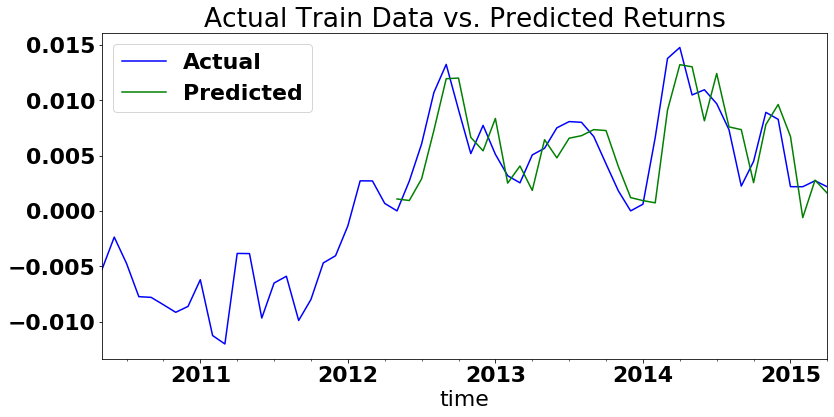

In [101]:
train_RMSE(train, results)

/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/bryanjamieson/opt/anacond

SARIMA model RMSE on test data: 0.00208


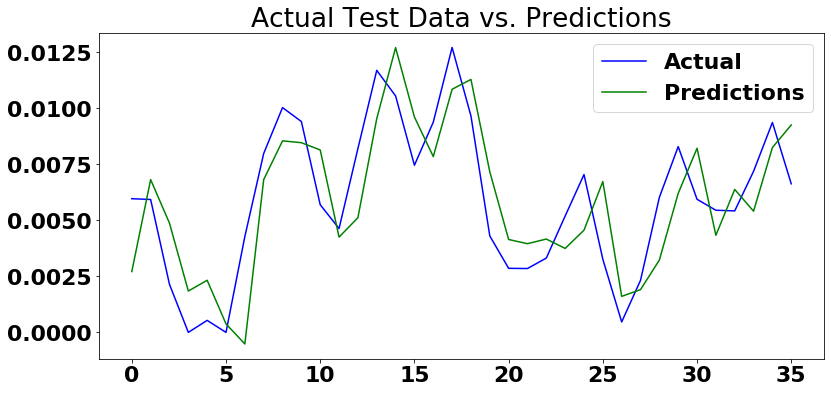

In [102]:
test_RMSE(ts_30101,pdq=pdq,pdqs=pdqs, display=True)

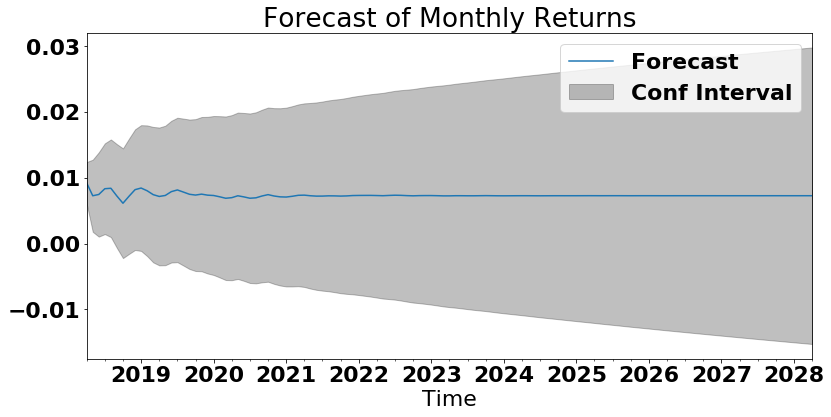

Expected 1yr return: 9.74%
Expected 3yr return: 30.65%
Expected 5yr return: 55.5%
Expected 10yr return: 141.87%


In [103]:
mr_30101=forecast_model(ts_30101,pdq=pdq,pdqs=pdqs, z=30101)

# Format data from horizontal to vertical
* Grab the date values from each zip code and make it a column in our new dataframe

In [ ]:
#new_df  = pd.DataFrame()
#new_df['dates'] = dates

#for index in range(df_GA_2.shape[0]):
#    row = df_GA_2.iloc[index]
#    region_name = row['RegionName']
#    date_values = row[dates].values
#    new_df[region_name] = date_values
#new_df.head()

In [ ]:
#for zipcode in df.RegionName:
#    row = df[df.RegionName==zipcode].iloc[:,7:]
#    new_df[zipcode] = row.values[0]
#new_df.set_index('dates',inplace=True)

# Change 'dates' column to datetime format

# Set 'dates' column as our index

# Step 3: EDA and Visualization

In [ ]:
# Above we can see that Fulton is the most expensive county to live in and it's mean price has increased the most

In [ ]:
# insert zip code selection from "https://medium.com/@feraguilari/time-series-analysis-modfinalproyect-b9fb23c28309"
# Find top 5 zipcodes in Fulton by ROI - aka add new cell with ROI by zip
# Then do forcast for 10 year ROI

In [ ]:
# Add Rolling mean and std for zipcodes
# Add ADFuller test

# Step 4: Reshape from Wide to Long Format

In [ ]:
# Time Series Analysis here

# Step 5: ARIMA Modeling

In [ ]:
#split_date = '2017-08'
#training, validation = summary_df[:split_date].Region, summary_df[split_date:].Region
#ts = summary_df.Region

In [ ]:
#p_values = [0, 1, 2, 4, 6, 8, 10]
#d_values = range(0, 3)
#q_values = range(0, 3)
#warnings.filterwarnings("ignore")
#evaluate_models(summary_df.values, p_values, d_values, q_values)

# Step 6: Interpreting Results